In [105]:
import cv2
from cv2 import threshold
import numpy as np
import sys
import os
import json
from torchvision import models
from tqdm import tqdm
from pytorch3d.renderer import look_at_view_transform
from math import ceil
import torch
from pytorch3d.io import load_obj, load_ply
from scipy.spatial.transform import Rotation as scipy_rot
from matplotlib import pyplot as plt
from probabilistic_formulation.tests.test_factors_lines import create_k3d_plot

%load_ext autoreload
%autoreload 2

from leveraging_geometry_for_shape_estimation.keypoint_matching.get_matches_3d import load_information_depth_camera,create_pixel_bearing,pb_and_depth_to_wc
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.pose import init_Rs,init_Ts,get_pb_real_grid,get_R_limits,get_T_limits, create_pose_info_dict, check_gt_pose_in_limits, get_nearest_pose_to_gt
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.ground_plane import get_model_to_infos,sample_Ts_ground_plane,filter_Ts
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.translation_from_lines_v3 import *
from leveraging_geometry_for_shape_estimation.probabilistic_pose_and_shape.visualise_T_factors import plot_lines_T_correct_visualisation
from leveraging_geometry_for_shape_estimation.segmentation.meshrcnn_vis_tools import draw_boxes
from leveraging_geometry_for_shape_estimation.utilities.write_on_images import draw_lines

from probabilistic_formulation.utilities import create_all_possible_combinations,get_uvuv_p_from_superpoint,create_all_possible_combinations_uvuv_p_together
from probabilistic_formulation.factors.factors_T.factors_lines_multiple_T import get_factor_reproject_lines_multiple_T, get_factor_reproject_lines_multiple_T_threshold, get_factor_reproject_lines_multiple_T_with_Scale
from probabilistic_formulation.factors.factors_T.bbox import get_factor_bbox_multiple_T
from probabilistic_formulation.tests.test_reproject_lines import load_lines_2D,load_lines_3D,get_cuboid_line_dirs_3D,plot_lines_T,plot_bbox, plot_points_T

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [106]:
# exp_path = '/scratches/octopus_2/fml35/experiments/leveraging_geometry_for_shape/exp_186_roca_retrieval_gt_z_lines_octopus'
# exp_path = '/scratches/octopus_2/fml35/experiments/leveraging_geometry_for_shape/exp_205_filtering_2d_lines_based_on_n_pixel'
exp_path = '/scratches/octopus_2/fml35/experiments/leveraging_geometry_for_shape/exp_206_filtered_lines'
global_info = exp_path + '/global_information.json'
with open(global_info,'r') as f:
    global_config = json.load(f)


# choose what gt
use_gt_retrieval = False
use_gt_R = True

# which lines
# line_indices = [0]
line_indices = None
point_size = 0.03


# what factors
global_config["pose_and_shape_probabilistic"]["sample_in_ground_plane"] = 'False'
# global_config["pose_and_shape_probabilistic"]["reproject_lines"]["multiplier_lines"] = 0.1
global_config["pose_and_shape_probabilistic"]["reproject_lines"]["multiplier_lines"] = 0.02
global_config["pose_and_shape_probabilistic"]["reproject_lines"]["signal"] = "lines"
# global_config["pose_and_shape_probabilistic"]["reproject_lines"]["signal"] = "bbox"
global_config["pose_and_shape_probabilistic"]["reproject_lines"]["enforce_same_length"] = True

global_config["pose_and_shape_probabilistic"]["reproject_lines"]["area_threshold_percentage_side_length"] = 0.1
global_config["pose_and_shape_probabilistic"]["reproject_lines"]["only_allow_single_mapping_to_3d"] = "True"

# info for grid sampling
# global_config["pose_and_shape_probabilistic"]["pose"] = {
#                     "gt_z": "True",
#                     "tilt":{"range": 20,"steps": 20},
#                     "elev":{"range": 45,"steps": 45},
#                     "azim":{"range": 45,"steps": 45},
#                     # "x":{"range": 0.3,"steps": 40},
#                     # "y":{"range": 0.3,"steps": 40},
#                     "x":{"range": 1.0,"steps": 40},
#                     "y":{"range": 1.0,"steps": 40},
#                     "z":{"range": 5,"steps": 15}
#                 }

In [107]:
# choose which 3D lines
# old
# global_config["pose_and_shape_probabilistic"]["reproject_lines"]["line_dir_3d_precise"] = global_config["pose_and_shape_probabilistic"]["reproject_lines"]["line_dir_3d_precise"].replace('/scratch2/','/scratches/octopus_2/')
# new
global_config["pose_and_shape_probabilistic"]["reproject_lines"]["line_dir_3d_precise"] = '/scratches/octopus_2/fml35/experiments/leveraging_geometry_for_shape/exp_117_scannet_models/models/extract_from_2d/exp_03/lines_3d_reformatted'

In [108]:
# choose 2D lines
line_dir_2d = exp_path + '/lines_2d_filtered'
# new lines
# line_dir_2d = '/scratches/octopus_2/fml35/experiments/leveraging_geometry_for_shape/exp_205_filtering_2d_lines_based_on_n_pixel/lines_2d_filtered'

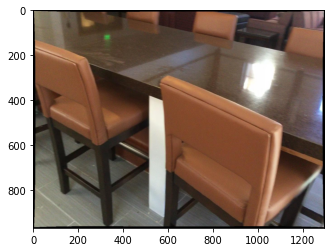

In [109]:

target_folder,models_folder_read,top_n_retrieval,top_n_for_translation,pose_config,sensor_width,device = get_variables(global_config)
target_folder = target_folder.replace('/scratch2/','/scratches/octopus_2/')
models_folder_read = models_folder_read.replace('/scratch2/','/scratches/octopus_2/')

model_to_infos = get_model_to_infos()

# scene0011_01-000400_00_000_03_chair
# name = 'scene0011_01-000400_00_000_03.json'
# name = 'scene0011_00-001200_01_000_02.json'
# name = 'scene0025_00-001400_00_000_01.json'
# name = 'scene0430_00-000400_01_000_00.json'
# name = 'scene0598_01-000400_00_000_00.json'
# name = 'scene0011_00-001900_03_000_01.json'
name = 'scene0011_01-000200_00_000_00.json' # bug with mapping ?? no all correct


retrieval = name.rsplit('_',1)[0]
detection = name.rsplit('_',2)[0]
gt_name = name.rsplit('_',3)[0]
nn_index = int(retrieval.split('_')[-1])

visualisation_list,retrieval_list,gt_infos,segmentation_infos,bbox_overlap = load_infos(target_folder,detection,gt_name)
output_path = target_folder + '/poses/' + name
if use_gt_retrieval:
    retrieval_list[nn_index]["model"] = gt_infos["objects"][bbox_overlap['index_gt_objects']]["model"]

input_img = cv2.imread(target_folder + '/images/' + gt_infos['img'])
input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
plt.imshow(input_img)
plt.show()




model/chair/d6da5457b0682e24696b74614952b2d0/model_normalized.obj


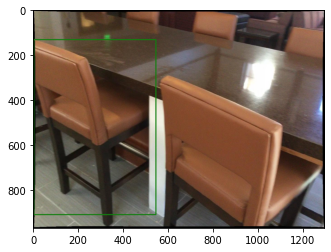

In [110]:
f,w,h,sw,enforce_same_length,gt_rot,gt_trans,gt_scaling,gt_z = get_infos_gt(gt_infos,pose_config,global_config,bbox_overlap)
B = get_pb_real_grid(w,h,f,sw,device)
bbox = segmentation_infos["predictions"]["bbox"]
model_path = get_model_path(retrieval_list,nn_index,gt_infos,bbox_overlap,gt=use_gt_retrieval)
print(model_path)
box_img = draw_boxes(input_img, np.array([bbox]), thickness=3)
plt.imshow(box_img)
plt.show()

In [111]:
def get_angle(m1,m2):

    m = np.matmul(np.array(m1).T,np.array(m2))

    value = (np.trace(m) - 1 )/ 2

    clipped_value = np.clip(value,-0.9999999,0.999999)

    angle = np.arccos(clipped_value)

    return angle * 180 / np.pi 

In [112]:
R,tilts,azims,elevs = get_R(target_folder,name,gt_infos,bbox_overlap,gt=use_gt_R)
R_gt,_,_,_ = get_R(target_folder,name,gt_infos,bbox_overlap,gt=True)

Ss = get_S(gt_scaling,gt=True)
Ts,xs,ys,zs = get_Ts(f,w,h,sensor_width,global_config,bbox,gt_z,model_path,model_to_infos,gt_scaling,segmentation_infos,R)

print('R',R)
print('Ss',Ss)
print('Ts',Ts.shape)
print('Ts',Ts[:3])

print(get_angle(R,R_gt))


R [[-0.8144056567449547, -0.05394517885312504, 0.5777825803557626], [-0.3513255011649246, 0.8382909045901884, -0.41693841192368414], [-0.46185797222054054, -0.5425472426125504, -0.7016613747563204]]
Ss [[0.97667308 1.31681761 1.16354287]]
Ts (1600, 3)
Ts [[ 0.26634564 -0.45297027  1.4710786 ]
 [ 0.26634564 -0.43283556  1.4710786 ]
 [ 0.26634564 -0.41270085  1.4710786 ]]
0.0952585792203633


USE SCALIGN for mask 3d lines
use old function without scale
sorted_lines_smaller_threshold tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True, False, False, False, False, False, False, False,
         False, False, False, False, 

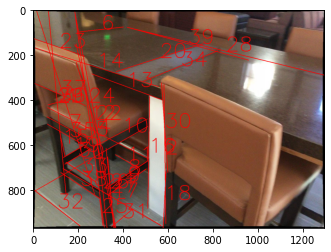

In [113]:

# compute factors
Ts = torch.Tensor(Ts)
signal = global_config["pose_and_shape_probabilistic"]["reproject_lines"]["signal"]
if signal == 'bbox' or signal == 'lines':
    best_T_index,best_S_index,max_factor,lines_3D,lines_2D,lines_available,multiplier_lines,factors,area_threshold,angle_threshold,only_allow_single_mapping_to_3d = signal_bbox_or_line(global_config,model_path,target_folder,detection,device,R,Ts,bbox,f,w,h,sw,Ss,B,enforce_same_length,top_n_for_translation,line_dir_2d,line_indices)
print('max_factor',max_factor)
print('lines_3D.shape',lines_3D.shape)
print('lines_2D.shape',lines_2D.shape)
img_lines = draw_lines(input_img,lines_2D,draw_indices=True)
plt.imshow(img_lines)
plt.show()

In [114]:

create_k3d_plot(np.array(Ts),np.array(factors),gt_trans,point_size)
T = Ts[best_T_index]
S = Ss[best_S_index]

print('T',T)
print('S',S)
print('R',R)


Output()

T tensor([ 0.4655, -0.0301,  1.4711])
S [0.97667308 1.31681761 1.16354287]
R [[-0.8144056567449547, -0.05394517885312504, 0.5777825803557626], [-0.3513255011649246, 0.8382909045901884, -0.41693841192368414], [-0.46185797222054054, -0.5425472426125504, -0.7016613747563204]]


sorted_lines_smaller_threshold tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True, False, False, False, False, False, False, False, False]])
accepted_2d_line tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True, False, False, False, False, False, False, False, False]])


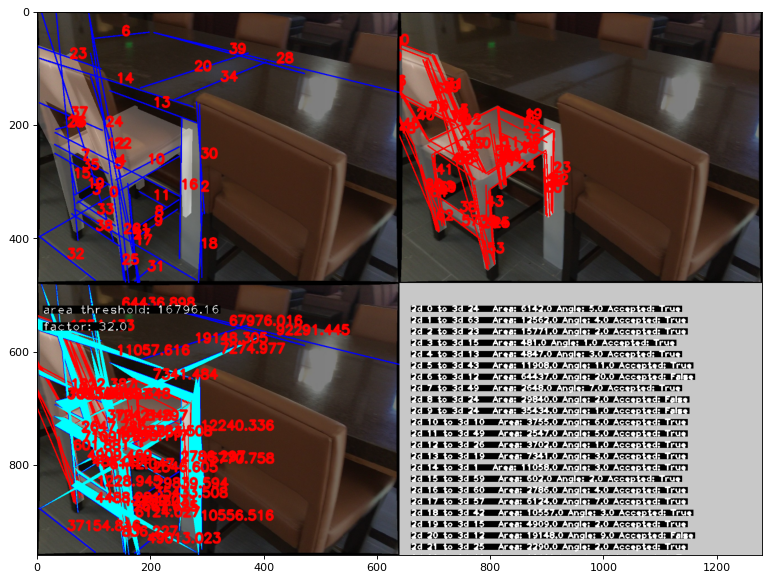

sorted_lines_smaller_threshold tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True, False, False, False,
         False, False, False, False, False, False, False, False, False, False]])
accepted_2d_line tensor([[ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True, False, False, False,
         False, False, False, False, False, False, False, False, False, False]])


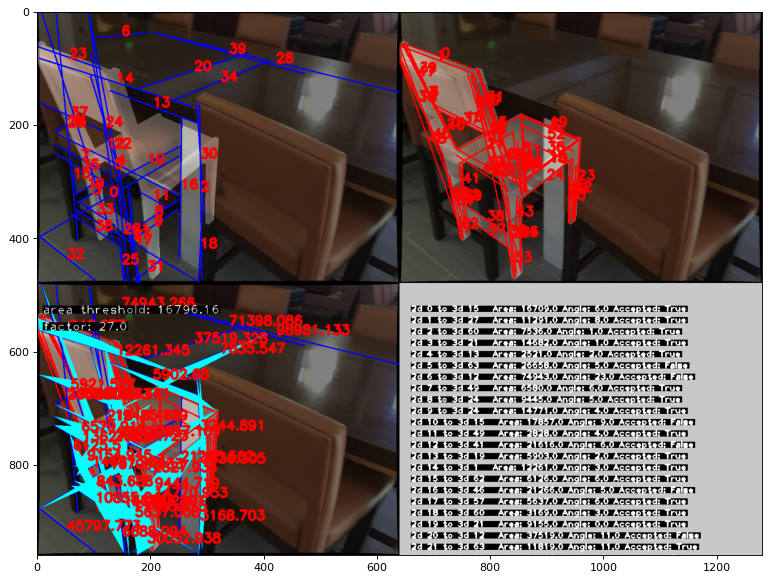

In [117]:

closest_gt_t_index = get_closest_index(Ts,gt_trans)
closest_gt_s_index = get_closest_index(torch.Tensor(Ss),gt_scaling)

for which,l,s in zip(['selected','closest_gt'],[best_T_index,closest_gt_t_index],[best_S_index,closest_gt_s_index]):
# for which,l,s in zip(['selected'],[best_T_index],[best_S_index]):
    T = Ts[l]
    S = Ss[s]
    img_path = target_folder + '/images/' + gt_infos["img"]
    full_model_path = global_config["dataset"]["dir_path"].replace('/scratch2/','/scratches/octopus_2/') + model_path

    if signal == 'bbox':
        if not lines_3D.shape[0] == 0:
            img = plot_bbox(torch.Tensor(R).unsqueeze(0),torch.Tensor(T).unsqueeze(0).unsqueeze(0),gt_scaling,full_model_path,img_path,sw,device,lines_3D,f,torch.Tensor(bbox))
    elif signal == 'lines':
        if lines_available:
            img = plot_lines_T_correct_visualisation(torch.Tensor(R).unsqueeze(0),torch.Tensor(T).unsqueeze(0).unsqueeze(0),S,full_model_path,img_path,sw,device,lines_3D,lines_2D,B,f,area_threshold,angle_threshold,only_allow_single_mapping_to_3d)
        else:
            img = cv2.imread(target_folder + '/images/' + gt_infos["img"])
            
    plt.figure(figsize=(12, 9), dpi=80)
    plt.imshow(img)
    plt.show()

# plot next to this which shows factors for gt pose, need to recalculate 

In [116]:
file_name = exp_path + '/T_lines_vis/' + name.replace('.json','_closest_gt.png')
assert os.path.exists(file_name)
original = cv2.imread(file_name)

plt.imshow(original)
plt.show()

file_name = exp_path + '/T_lines_vis/' + name.replace('.json','_selected.png')
assert os.path.exists(file_name)
original = cv2.imread(file_name)

plt.imshow(original)
plt.show()

# only top n 2d lines, use lines that map to different 3d lines
# factor use area of 4 endpoints
# treshold area 
# check if take sum in exponent 
# take n 

AssertionError: 

In [ ]:
def main_notebook(line_indices,global_config,model_path,target_folder,detection,device,R,Ts,bbox,f,w,h,sw,Ss,B,enforce_same_length,top_n_for_translation,line_dir_2d):
    # compute factors
    Ts = torch.Tensor(Ts)
    signal = global_config["pose_and_shape_probabilistic"]["reproject_lines"]["signal"]
    if signal == 'bbox' or signal == 'lines':
        best_T_index,best_S_index,max_factor,lines_3D,lines_2D,lines_available,multiplier_lines,factors = signal_bbox_or_line(global_config,model_path,target_folder,detection,device,R,Ts,bbox,f,w,h,sw,Ss,B,enforce_same_length,top_n_for_translation,line_dir_2d,line_indices)

    img_lines = draw_lines(input_img,lines_2D,draw_indices=True)
    plt.imshow(img_lines)
    plt.show()
    create_k3d_plot(np.array(Ts),np.array(factors),gt_trans,point_size)
    T = Ts[best_T_index]
    S = Ss[best_S_index]

    closest_gt_t_index = get_closest_index(Ts,gt_trans)
    closest_gt_s_index = get_closest_index(torch.Tensor(Ss),gt_scaling)

    # for which,l,s in zip(['selected','closest_gt'],[best_T_index,closest_gt_t_index],[best_S_index,closest_gt_s_index]):
    for which,l,s in zip(['selected'],[best_T_index],[best_S_index]):
        T = Ts[l]
        S = Ss[s]
        img_path = target_folder + '/images/' + gt_infos["img"]
        full_model_path = global_config["dataset"]["dir_path"].replace('/scratch2/','/scratches/octopus_2/') + model_path

        if signal == 'bbox':
            if not lines_3D.shape[0] == 0:
                img = plot_bbox(torch.Tensor(R).unsqueeze(0),torch.Tensor(T).unsqueeze(0).unsqueeze(0),gt_scaling,full_model_path,img_path,sw,device,lines_3D,f,torch.Tensor(bbox))
        elif signal == 'lines':
            if lines_available:
                img = plot_lines_T(torch.Tensor(R).unsqueeze(0),torch.Tensor(T).unsqueeze(0).unsqueeze(0),S,full_model_path,img_path,sw,device,lines_3D,lines_2D,B,f,top_n_for_translation,multiplier_lines,enforce_same_length)
            else:
                img = cv2.imread(target_folder + '/images/' + gt_infos["img"])
                
        cv2.putText(img, 'gt' + str(np.round(gt_trans,3)), (100,100), cv2.FONT_HERSHEY_SIMPLEX, 2,(255, 128, 0), 1, cv2.LINE_AA)
        cv2.putText(img, str(np.round(T.numpy(),3)), (100,400), cv2.FONT_HERSHEY_SIMPLEX, 2,(255, 128, 0), 1, cv2.LINE_AA)
        plt.imshow(img)
        plt.show()

In [ ]:
# list_all_line_indices = [[0,1,2],[4,5]]
for line_indices in list_all_line_indices:
    main_notebook(line_indices,global_config,model_path,target_folder,detection,device,R,Ts,bbox,f,w,h,sw,Ss,B,enforce_same_length,top_n_for_translation,line_dir_2d)

NameError: name 'list_all_line_indices' is not defined